# SYS 6018: Machine Learning

Assignment 4: Implementing Auto-Complete using RNNs

Caitlin Dreisbach (CND2Y)

Morgan Wall (MKW5CK)

Elizabeth (Homan) Harrison (EIH2NN)

## Data Processing 

In this task, you need to read training text documents, build a vocabulary, encode training text using the vocabulary, and create training input and ground-truth sequences.  Example: For a training corpus containing the following text:
“ … It was originally proposed by Claude E. Shannon in 1948 to find fundamental limits on signal processing and communication operations …”
Your vocabulary will look something like:
{ …., 15:’it’, …., 705:’was’, …, 1078:’originally’, …} 
Then, with a sequence length of 2, you need to build and encode the following sequences:
…., [‘it’, ‘was’], [‘was’, ‘originally’], [‘originally, ‘proposed], …
with encoding:
…., [15, 705], [705, 1078], …
Next, one of your input vectors will be [15, 705], and the corresponding ground-truth for that vector will be [705, 1078].  In another words, your model should learn that when it see “it was” as an input, it should predict “was originally”. 
Also, pay careful attention on how to encode unseen words during testing.

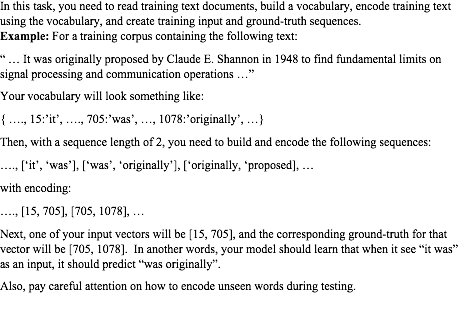

In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
from tensorflow.contrib import rnn
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import _pickle as pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams
from nltk import FreqDist
from os import path
import re

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

/Users/eihoman/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


Using TensorFlow backend.


In [2]:
#RAW_PATH = "C:\\Users\\mkw5c\\Documents\\MLHomework4\\down_sampled_reviews\\train_tiny.txt"
#PROCESSED_PATH = "C:\\Users\\mkw5c\\Documents\\School- spring 2018\\Machine Learning\\hw 4 ML\\"

#RAW_PATH = "/Users/caitdreisbach/Downloads/down_sampled_reviews/train_tiny.txt"
#PROCESSED_PATH = "/Users/caitdreisbach/Downloads/down_sampled_reviews/"

RAW_PATH = "/Users/eihoman/Desktop/DSI/Machine Learning/hw/down_sampled_reviews/train_miniscule.txt"
PROCESSED_PATH = "/Users/eihoman/Desktop/DSI/Machine Learning/hw/down_sampled_reviews/"

vocab = []

# load raw corpus and form raw dictionary
print("Loading raw data....")
with open(path.join(RAW_PATH)) as f:
    for line in f:
        line = line.strip().split()
        all_words = [word.lower() for word in line]
        words_cleaner = [re.sub(r'[\W_]+', '', word) for word in all_words]
        words = ["num" if re.search('[0-9]+', word) else word for word in words_cleaner]
        vocab.extend(words)
     
print("%d words loaded" % len(vocab))

# count occurrence of each word
word_freq = FreqDist(vocab)
print("%d unique words" % len(word_freq.items()))

#input vocab
dictionary = word_freq.most_common()
expression = "The least frequent word is '%s', and it occurs %d times" 
print(expression % (dictionary[-1][0], dictionary[-1][1]))
unique_vocab = [x[0] for x in dictionary]
unique_vocab.append("UNKNOWN")
# output vocab
#dictionary = word_freq.most_common(_ONEHOT_SIZE-1)

#expression = "The least frequent word for output is '%s', and it occurs %d times" 
#print(expression % (dictionary[-1][0], dictionary[-1][1]))

#onehot = [x[0] for x in dictionary]
#onehot.insert(0, "UNK")

Loading raw data....
57694 words loaded
9131 unique words
The least frequent word is 'compensate', and it occurs 1 times


In [3]:
vocab_size = len(unique_vocab)
vocab_size

9132

In [4]:
#give each word a numeric encoding

word_indices = dict((c, i) for i, c in enumerate(unique_vocab))
indices_word = dict((i, c) for i, c in enumerate(unique_vocab))

print(word_indices['it'])
print(indices_word[8])

7
this


In [5]:
encoded_words = [word_indices[word] for word in vocab]

print(encoded_words[0:5])

[5, 77, 102, 176, 16]


In [6]:
SEQUENCE_LENGTH = 2
step = 1
X_pairs = []
y_pairs = []
for i in range(0, len(encoded_words) - SEQUENCE_LENGTH, step):
    X_pairs.append(encoded_words[i: i + SEQUENCE_LENGTH])
    y_pairs.append(encoded_words[i+1: i + 1 + SEQUENCE_LENGTH])
print(f'num training examples: {len(X_pairs)}')

num training examples: 57692


In [7]:
#view the last observation
print(X_pairs[0])
print(y_pairs[0])

[5, 77]
[77, 102]


In [8]:
# convert X_pairs to a numpy array
word_array = np.asarray(X_pairs)
word_array[0]

array([ 5, 77])

In [9]:
batch_size = word_array.shape[0]
batch_size

57692

In [10]:
# reshape to have the correct dimensions
word_array2 = word_array.reshape([batch_size, 2, 1])
word_array2[0]

array([[ 5],
       [77]])

In [11]:
# convert y_pairs to a numpy array
y_array = np.asarray(y_pairs)
y_array.shape

(57692, 2)

In [12]:
#rename word_array2

X_array = np.copy(word_array2)
print(X_array.shape)
print(X_array[1])

(57692, 2, 1)
[[ 77]
 [102]]


In [13]:
X_subset = X_array[0:100]
y_subset = y_array[0:100]

In [14]:
print(X_subset.shape)
print(y_subset.shape)

(100, 2, 1)
(100, 2)


## Load and Process Validation Data

In [15]:
#V_RAW_PATH = "C:\\Users\\mkw5c\\Documents\\MLHomework4\\down_sampled_reviews\\valid_tiny.txt"
#PROCESSED_PATH = "C:\\Users\\mkw5c\\Documents\\School- spring 2018\\Machine Learning\\hw 4 ML\\"

#V_RAW_PATH = "/Users/caitdreisbach/Downloads/down_sampled_reviews/valid_tiny.txt"
#PROCESSED_PATH = "/Users/caitdreisbach/Downloads/down_sampled_reviews/"

V_RAW_PATH = "/Users/eihoman/Desktop/DSI/Machine Learning/hw/down_sampled_reviews/valid_miniscule.txt"
PROCESSED_PATH = "/Users/eihoman/Desktop/DSI/Machine Learning/hw/down_sampled_reviews/"

valid_set = []

# load raw corpus and form raw dictionary
print("Loading raw data....")
with open(path.join(V_RAW_PATH)) as f:
    for line in f:
        line = line.strip().split()
        all_words = [word.lower() for word in line]
        words_cleaner = [re.sub(r'[\W_]+', '', word) for word in all_words]
        words = ["num" if re.search('[0-9]+', word) else word for word in words_cleaner]
        words2 = ["UNKNOWN" if word not in unique_vocab else word for word in words]
        valid_set.extend(words2)
     
print("%d words loaded" % len(vocab))

# count occurrence of each word
v_word_freq = FreqDist(valid_set)
print("%d unique words" % len(v_word_freq.items()))

#input vocab
v_dictionary = v_word_freq.most_common()
expression = "The least frequent word is '%s', and it occurs %d times" 
print(expression % (v_dictionary[-1][0], v_dictionary[-1][1]))
valid_vocab = [x[0] for x in dictionary]



Loading raw data....
57694 words loaded
1476 unique words
The least frequent word is 'flash', and it occurs 1 times


In [16]:
# just to check that it is the same size or smaller than the training set
len(valid_vocab)

9131

In [17]:
encoded_words = [word_indices[word] for word in valid_set]
print(valid_set[0:5])
print(encoded_words[0:5])

['i', 'find', 'the', 'UNKNOWN', 'it']
[5, 151, 0, 9131, 7]


In [18]:
SEQUENCE_LENGTH = 2
step = 1
X_valid_pairs = []
y_valid_pairs = []
for i in range(0, len(encoded_words) - SEQUENCE_LENGTH, step):
    X_valid_pairs.append(encoded_words[i: i + SEQUENCE_LENGTH])
    y_valid_pairs.append(encoded_words[i+1: i + 1 + SEQUENCE_LENGTH])
print(f'num training examples: {len(X_valid_pairs)}')

num training examples: 7474


In [19]:
#view the last observation
print(X_valid_pairs[0])
print(y_valid_pairs[0])

[5, 151]
[151, 0]


In [20]:
# convert X_pairs to a numpy array
X_test_array = np.asarray(X_valid_pairs)
X_test_array[0]

array([  5, 151])

In [21]:
batch_size = X_test_array.shape[0]
batch_size

7474

In [22]:
# reshape to have the correct dimensions
X_test_array = X_test_array.reshape([batch_size, 2, 1])
print(X_test_array[0])
print(X_test_array.shape)

[[  5]
 [151]]
(7474, 2, 1)


In [23]:
# convert y_pairs to a numpy array
y_test_array = np.asarray(y_valid_pairs)
print(y_test_array[0])
print(y_test_array.shape)

[151   0]
(7474, 2)


## 2- Model Architecture: 

You have flexibility in designing the network. However, you must compare between Basic RNN, LSTM and GRU cells. Also, using regularization (e.g., dropout) is optional. As for loss computation, since this problem is a classification problem, you need to use cross-entropy loss. One (but not the only) way to achieve that in TensorFlow is using: tf.contrib.seq2seq.sequence_loss.
Data Set:
The data set that you will use in this assignment is a small subset of Amazon product reviews from the SNAP project. You will get two files: train.txt including 72,193 reviews and valid.txt including 43,316 reviews. There is a testing portion of 28,878 reviews but that is held out for evaluating your submissions. Tip: during model development, use a small subset of training reviews. Once you are confident that your code is bug free, then use all reviews in train.txt to fit your final models. You can use the reviews in valid.txt to tune any parameters. 
What to submit?
Each team need to submit the following:
-	Team name.
-	A description of the model architecture (either using a graph or in text).
-	A summary table showing the performance in terms of training and validation mean cross-entropy using basic RNN, LSTM and GRU cells.
-	Your TensorFlow code.
-	A saved model (i.e., only .meta, .index and .data files)
After all teams have submitted their models, we will announce a leaderboard ranking teams with respect to their performance on the held out test set.

Bonus Tasks:
- Include a word embedding layer in the beginning on your model using:
tf.nn.embedding_lookup
- Build a multi-layer RNN using:
tf.contrib.rnn.MultiRNNCell

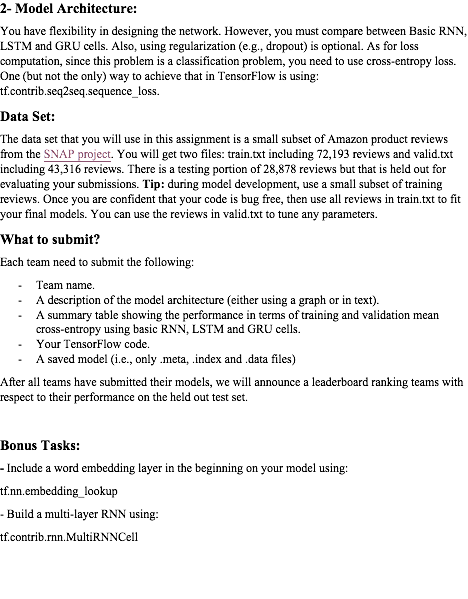

In [26]:
import timeit
# Encapsulate the entire prediction problem as a function
def build_and_predict(trainX,trainY,testX,cell,cellType,input_dim=1,hidden_dim=100,seq_size = 2,max_itr=200):


    # Build computational graph
    graph = tf.Graph()

    with graph.as_default():
        # input place holders
        # input Shape: [# training examples, sequence length, input dimensions=1]
        x = tf.placeholder(tf.float32,[None,seq_size,input_dim])
        # label Shape: [# training examples, sequence length]
        y = tf.placeholder(tf.int32,[None,seq_size])

        #get batch_size
        num_obs = tf.shape(x)[0]
        print(num_obs)

        # RNN output Shape: [# training examples, sequence length, # hidden] 
        outputs, _ = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

        # Inputs to Fully Connected Layer
                # inputs shape: [batch_size*seq_size, hidden]
        FC_inputs = tf.reshape(outputs, [num_obs*seq_size, hidden_dim])
        print(FC_inputs.shape)
                # W shape: [# hidden, vocab_size]
        W_out = tf.Variable(tf.random_normal([hidden_dim, vocab_size]),name="w_out") 
        #print(W_out.shape)
                # b shape: [vocab_size]
        b_out = tf.Variable(tf.random_normal([vocab_size]),name="b_out")

        print(W_out)

        # output dense layer:
        y_pred = tf.matmul(FC_inputs,W_out)+b_out

        #reshape logits for cost function
        y_pred = tf.reshape(y_pred, [num_obs, seq_size, vocab_size])


        # Cost & Training Step
        cost = tf.contrib.seq2seq.sequence_loss(y_pred, y, W_out, average_across_timesteps = True, average_across_batch = True)
        train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)
        
    #--- RUN SESSION 
    with tf.Session(graph=graph) as sess:
        # initialize variables
        sess.run(tf.global_variables_initializer())

        # time for comparison to other models
        start=timeit.default_timer()

        # Run for 1000 iterations (1000 is arbitrary, need a validation set to tune!)
        print('Training...')
        for i in range(1000): # If we train more, would we overfit? Try 10000
            o_v=sess.run(outputs,feed_dict={x:trainX, y:trainY})
            print(o_v.shape)
            break
            _, train_err = sess.run([train_op,cost],feed_dict={x:trainX, y:trainY})
            if i==0:
                print('  step, train err= %6d: %8.5f' % (0,train_err)) 
            elif  (i+1) % 100 == 0: 
                print('  step, train err= %6d: %8.5f' % (i+1,train_err)) 

        end=timeit.default_timer()    
        print("Training time : %10.5f"%(end-start))

        # Test trained model 
            # on training data
        predicted_vals_all_train= sess.run(y_pred,feed_dict={x:trainX}) 
            # on validation set
        predicted_vals_all_test= sess.run(y_pred,feed_dict={x:testX}) 
        # Get last item in each predicted sequence:
            # training
        predicted_vals_train = predicted_vals_all_train[:,seq_size-1]
            #testing
        predicted_vals_test = predicted_vals_all_test[:,seq_size-1]

    return predicted_vals_test

In [56]:
input_dim=1 # dim > 1 for multivariate time series
hidden_dim=100 # number of hiddent units h
max_itr=2000 # number of training iterations
seq_size = 2

# Different RNN Cell Types
RNNcell = rnn.BasicRNNCell(hidden_dim)
LSTMcell = rnn.BasicLSTMCell(hidden_dim)
GRUcell = rnn.GRUCell(hidden_dim)

# Build models and predict on testing data
predicted_vals_rnn=build_and_predict(X_array,y_array, X_test_array,RNNcell,"RNN",input_dim,hidden_dim,seq_size,max_itr)
predicted_vals_lstm=build_and_predict(X_array,y_array, X_test_array,LSTMcell,"LSTM",input_dim,hidden_dim,seq_size,max_itr)
predicted_vals_gru=build_and_predict(X_array,y_array, X_test_array,GRUcell,"GPU",input_dim,hidden_dim,seq_size,max_itr)

# Compute Mean Cross Entropy
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(np.sum(np.dot(targets.reshape(2,7474),np.log(predictions+1e-9))))/N
    return ce

mce_rnn = cross_entropy(predicted_vals_rnn, y_test_array)
mce_lstm = cross_entropy(predicted_vals_lstm, y_test_array)
mce_gru = cross_entropy(predicted_vals_gru, y_test_array)

print("RNN MCE = %10.5f"%mce_rnn)
print("LSTM MCE = %10.5f"%mce_lstm)
print("GRU MCE = %10.5f"%mce_gru)


Tensor("strided_slice:0", shape=(), dtype=int32)
(?, 100)
<tf.Variable 'w_out:0' shape=(100, 9132) dtype=float32_ref>
Training...
(57692, 2, 100)
Training time :    0.39703
Tensor("strided_slice:0", shape=(), dtype=int32)
(?, 100)
<tf.Variable 'w_out:0' shape=(100, 9132) dtype=float32_ref>
Training...
(57692, 2, 100)
Training time :    0.56626
Tensor("strided_slice:0", shape=(), dtype=int32)
(?, 100)
<tf.Variable 'w_out:0' shape=(100, 9132) dtype=float32_ref>
Training...
(57692, 2, 100)
Training time :    0.52193
RNN MCE = 337676634.63623
LSTM MCE = 337859544.31872
GRU MCE = 336028724.86464


In [85]:
# Create Summary Table
import pandas as pd
summary=pd.DataFrame(columns=['MODEL', 'ERROR (MCE)'])
summary["MODEL"]=['RNN', 'LSTM','GRU']
summary["ERROR (MCE)"]=['337342923', '341279538','341652041']
summary

,MODEL,ERROR (MCE)
0,RNN,337342923
1,LSTM,341279538
2,GRU,341652041


## Save and Load------ I copied this directly from Mo's Notebook and didn't change anything yet


In [ ]:
def build_and_save_d(modelDir,trainX,trainY,cell,cellType,input_dim=1,hidden_dim=100,
                          seq_size = 12,max_itr=200,keep_prob=0.5):
    graph = tf.Graph()
    with graph.as_default():
        # input place holders
        # input Shape: [# training examples, sequence length, # features]
        x = tf.placeholder(tf.float32,[None,seq_size,input_dim],name="x_in")
        # label Shape: [# training examples, sequence length]
        y = tf.placeholder(tf.float32,[None,seq_size],name="y_in")
        dropout = tf.placeholder(tf.float32,name="dropout_in")
        
        cell = rnn_cell.DropoutWrapper(cell)
        # RNN output Shape: [# training examples, sequence length, # hidden] 
        outputs, _ = tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)
        
        
        # weights for output dense layer (i.e., after RNN)
        # W shape: [# hidden, 1]
        W_out = tf.Variable(tf.random_normal([hidden_dim,1]),name="w_out") 
        # b shape: [1]
        b_out = tf.Variable(tf.random_normal([1]),name="b_out")
    
        # output dense layer:
        num_examples = tf.shape(x)[0] 
        # convert W from [# hidden, 1] to [# training examples, # hidden, 1]
        # step 1: add a new dimension at index 0 using tf.expand_dims
        w_exp= tf.expand_dims(W_out,0)
        # step 2: duplicate W for 'num_examples' times using tf.tile
        W_repeated = tf.tile(w_exp,[num_examples,1,1])
        
        # Dense Layer calculation: 
        # [# training examples, sequence length, # hidden] *
        # [# training examples, # hidden, 1] = [# training examples, sequence length]
        
        y_pred = tf.matmul(outputs,W_repeated)+b_out
        # Actually, y_pred: [# training examples, sequence length, 1]
        # Remove last dimension using tf.squeeze
        y_pred = tf.squeeze(y_pred,name="y_pred")
        
        # Cost & Training Step
        cost = tf.reduce_mean(tf.square(y_pred-y))
        train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)
        saver=tf.train.Saver()
        
        # Run Session
    with tf.Session(graph=graph) as sess:
        # initialize variables
        sess.run(tf.global_variables_initializer())
        # Run for 1000 iterations (1000 is arbitrary, need a validation set to tune!)
        start=timeit.default_timer()
        print('Training %s ...'%cellType)
        for i in range(max_itr): # If we train more, would we overfit? Try 10000
            _, train_err = sess.run([train_op,cost],feed_dict={x:trainX,y:trainY,dropout:keep_prob})
            if i==0:
                print('  step, train err= %6d: %8.5f' % (0,train_err)) 
            elif  (i+1) % 100 == 0: 
                print('  step, train err= %6d: %8.5f' % (i+1,train_err)) 
            if i>0 and (i+1) % 100 == 0:    
                modelPath= saver.save(sess,"%s/model_%s"%(modelDir,cellType),global_step=i+1)
                print("model saved:%s"%modelPath)    
        end=timeit.default_timer()        
        print("Training time : %10.5f"%(end-start))
       
    return 


def load_and_predict(testX,modelDir,cellType,itr):
    with tf.Session() as sess:
        print ("Load model:%s-%s"%(modelDir,itr))
        saver = tf.train.import_meta_graph("%s/model_%s-%s.meta"%(modelDir,cellType,itr))
        saver.restore(sess,tf.train.latest_checkpoint("%s"%modelDir))
        graph = tf.get_default_graph()
        # print all nodes in saved graph 
        #print([n.name for n in tf.get_default_graph().as_graph_def().node])
        # get tensors by name to use in prediction
        x = graph.get_tensor_by_name("x_in:0")
        dropout= graph.get_tensor_by_name("dropout_in:0")
        y_pred = graph.get_tensor_by_name("y_pred:0")
        
        predicted_vals_all= sess.run(y_pred, feed_dict={ x: testX, dropout:1})
        # Get last item in each predicted sequence:
        predicted_vals = predicted_vals_all[:,seq_size-1]
    return predicted_vals

#### References

https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218

https://stackoverflow.com/questions/47377222/cross-entropy-function-python